In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

import seaborn as sns
from progressbar import ProgressBar
from sklearn.preprocessing import MinMaxScaler
import scipy
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.layers import Dense, Input, Conv1D, MaxPooling1D, Reshape, Flatten, GlobalMaxPooling1D, Layer
from tensorflow.keras.layers import Dropout, ReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MeanSquaredError
from keras.initializers import glorot_normal
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from tensorflow.keras import Model
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as rmse

plt.rcParams.update({'font.size': 18})

2023-03-03 17:54:00.995593: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-03 17:54:01.210155: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-03 17:54:01.889864: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-03 17:54:01.889939: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

## Load the new CMAPPS data

In [2]:
mypath = 'N-CMAPSS_DL/N-CMAPSS/Samples_whole/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print(onlyfiles)

train_units = [2,5,10,16,18,20]
test_units = [11,14,15]

test_files = [[f for f in onlyfiles if str(test_units[j]) in f ] for j in range(len(test_units))]
test_files = np.array(test_files)[:,0].tolist()
train_files = list(set(onlyfiles) - set(test_files))

['Unit5_win1_str1_smp500.npz', 'Unit2_win1_str1_smp500.npz', 'Unit16_win1_str1_smp500.npz', 'Unit10_win1_str1_smp500.npz', 'Unit18_win1_str1_smp500.npz', 'Unit20_win1_str1_smp500.npz', 'Unit11_win1_str1_smp500.npz', 'Unit14_win1_str1_smp500.npz', 'Unit15_win1_str1_smp500.npz']


## Make Input-Output for training the UQ models

In [3]:
def load_part_array_merge (current_dir, npz_units):
    sample_array_lst = []
    label_array_lst = []
    for npz_unit in npz_units:
      loaded = np.load(current_dir + npz_unit)
      sample_array_lst.append(loaded['sample'])
      label_array_lst.append(loaded['label'])
    sample_array = np.dstack(sample_array_lst)
    label_array = np.concatenate(label_array_lst)
    sample_array = sample_array.transpose(2, 0, 1)
    return sample_array, label_array

In [4]:
Xtrain_norm,Ytrain = load_part_array_merge(mypath,train_files)
Xtest_norm,Ytest = load_part_array_merge(mypath,test_files)
Xtrain_norm = Xtrain_norm[:,0,:]
Xtest_norm = Xtest_norm[:,0,:]
Ytrain_norm = (Ytrain)/np.max(Ytrain)
Ytest_norm = (Ytest)/np.max(Ytrain)

In [5]:
test_units = [11]
test_files = [[f for f in onlyfiles if str(test_units[j]) in f ] for j in range(len(test_units))]
test_files = np.array(test_files)[:,0].tolist()
Xtest11_norm,Ytest11 = load_part_array_merge(mypath,test_files)
Xtest11_norm = Xtest11_norm[:,0,:]
Ytest11_norm = np.expand_dims((Ytest11)/np.max(Ytrain),1)


test_units = [14]
test_files = [[f for f in onlyfiles if str(test_units[j]) in f ] for j in range(len(test_units))]
test_files = np.array(test_files)[:,0].tolist()
Xtest14_norm,Ytest14 = load_part_array_merge(mypath,test_files)
Xtest14_norm = Xtest14_norm[:,0,:]
Ytest14_norm = np.expand_dims((Ytest14)/np.max(Ytrain),1)


test_units = [15]
test_files = [[f for f in onlyfiles if str(test_units[j]) in f ] for j in range(len(test_units))]
test_files = np.array(test_files)[:,0].tolist()
Xtest15_norm,Ytest15 = load_part_array_merge(mypath,test_files)
Xtest15_norm = Xtest15_norm[:,0,:]
Ytest15_norm = np.expand_dims((Ytest15)/np.max(Ytrain),1)

## Utils

In [6]:
# Ensembling of individual models
def get_ensemble(pred_df, UQmodelcode, nmodels_select):
    """
    Input
    pred_df - dataframe with individual model predictions
              Columns named as "NN_mu_#ofmodel" and "NN_sigma_#ofmodel"
    UQmodelcode - 'NN' for neural network ensemble, 'MC' for MC dropout
    nmodels_select - number of individual models to form the ensemble
    """
    mu_cols = [UQmodelcode + "_mu_"+str(i) for i in range(nmodels_select)]
    sigma_cols = [UQmodelcode + "_sigma_"+str(i) for i in range(nmodels_select)]
    
    mu_eff = pred_df[mu_cols].mean(axis=1)
    if UQmodelcode=="NN":
        sigma_eff =  np.sqrt(np.mean(pred_df[mu_cols]**2, axis = 1)
                             + np.mean(pred_df[sigma_cols]**2, axis = 1)
                             - mu_eff**2)
    elif UQmodelcode=="MC": # no sigma_cols for individual models
        sigma_eff =  np.sqrt(np.mean(pred_df[mu_cols]**2, axis = 1)
                             - mu_eff**2)
    pred_df[UQmodelcode+"_mu_eff"] = mu_eff
    pred_df[UQmodelcode+"_sigma_eff"] = sigma_eff
    return pred_df
    
# Get calibration curves
def get_confidence_interval(y_true, mu, sigma):
    """
    Input: 
    y_true - true values
    mu     - predicted mean
    sigma  - predicted standard deviation
    
    Output:
    exp_CIs - expected confidence
    pred_CIs - predicted confidence
    """
    exp_CIs = np.linspace(1e-10, 1-1e-10, 1000) #expected CIs
    pred_CIs=[]                                 #predicted CIs
    for exp_CI in sorted(exp_CIs):
        intervals = scipy.stats.norm.interval(exp_CI, loc=mu, scale=sigma)
        lower_bd = intervals[0]
        upper_bd = intervals[1]
        pred_CIs.append(np.sum((y_true > lower_bd) & (y_true < upper_bd))/len(y_true))
    
    ECE = np.mean(np.abs(exp_CIs - pred_CIs))
    return 100*exp_CIs, 100*np.array(pred_CIs), 100*ECE  # converting to percentages

def get_rmse(y_true, y_pred):
    """
    Inputs:
    y_true - true values
    y_pred - predicted values
    Outputs:
    root mean squarred error
    """
    return np.sqrt(np.mean((y_true-y_pred)**2))

def get_nll(y_true, y_pred, s_pred):
    """
    Inputs:
    y_true - true values
    y_pred - predicted values
    s_pred - predicted standard deviation
    Outputs:
    median of NLL
    """
    return np.mean(np.log(s_pred**2)/2 + 
                     np.divide((y_true - y_pred)**2, 2* s_pred**2))

## Uncertainty Model 1: Deep Ensemble (DE)

In [7]:
# loss function and new custom layer to give mean and standard deviation
# Inspired from https://medium.com/@albertoarrigoni/paper-review-code-deep-ensembles-nips-2017-c5859070b8ce
def custom_loss(variance):
    def nll_loss(y_true, y_pred):
        return tf.reduce_mean(0.5*tf.math.log((variance)) + 
                              0.5*tf.math.divide(tf.math.square(y_true - y_pred), variance)) + 1e-6
    return nll_loss
class GaussianLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(GaussianLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.kernel_1 = self.add_weight(name='kernel_1', 
                                      shape=(10, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.kernel_2 = self.add_weight(name='kernel_2', 
                                      shape=(10, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.bias_1 = self.add_weight(name='bias_1',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        self.bias_2 = self.add_weight(name='bias_2',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        super(GaussianLayer, self).build(input_shape) 
    def call(self, x):
        output_mu  = K.dot(x, self.kernel_1) + self.bias_1
        output_sig = K.dot(x, self.kernel_2) + self.bias_2
        output_sig_pos = K.log(1 + K.exp(output_sig)) + 1e-06  
        return [output_mu, output_sig_pos]
    def compute_output_shape(self, input_shape):
        return [(input_shape[0], self.output_dim), (input_shape[0], self.output_dim)]

In [8]:
def generate_trained_NNmodel(trainX, trainY, nepochs, actfn = 'relu'):
    """
    Inputs:
    trainX  - training input of shape (samples, num of features)
    trainY  - training output of shape (samples, 1)
    nepochs - number of epochs
    actfn   - activation function
    Outputs:
    get_gl_function - Gaussian layer outputs as function 
    """
    num_res_layers = 2
    n_inp_features = np.shape(trainX)[1]
    feature_input = Input(shape=(n_inp_features,), name="feature_input_layer")
    x = Dense(100, activation = actfn)(feature_input)
    for _ in range(num_res_layers):
        x  = Dense(50, activation = actfn)(x)
        x1 = Dense(50, activation = actfn)(x)
        x = x1 + x
    x = Dense(10, activation = actfn)(x)
      
    mu, variance = GaussianLayer(1, name='main_output')(x)
    model = Model(feature_input, mu)
    model.compile(loss=custom_loss(variance), optimizer='adam')
    model.fit(trainX, trainY,shuffle=True, epochs=nepochs, verbose = 1)
    
    layer_name = 'main_output' # Where to extract the Gaussian output from. 
    get_gl_function = K.function(inputs=[model.input], 
                                  outputs=model.get_layer(layer_name).output)
    return get_gl_function

In [10]:
# First let us do a single run
prediction_fns, train_rmse = [], []
nmodels = 1    
nep = 50

pbar=ProgressBar()
for i in pbar(range(nmodels)):
    my_func = generate_trained_NNmodel(Xtrain_norm, Ytrain_norm, nepochs = nep, actfn = 'relu')
    train_rmse.append(get_rmse(Ytrain, (my_func(Xtrain_norm)[0])*np.max(Ytrain)))
    prediction_fns.append(my_func)
    
nmodels_select = 1  # select these # of models
final_NN_fns = []
for i in range(nmodels_select):
    final_NN_fns.append(prediction_fns[np.argsort(train_rmse)[:nmodels_select][i]])

Train on 10527 samples
Epoch 1/50
10527/10527 [==============================] - 1s 87us/sample - loss: -0.9901
Epoch 2/50
10527/10527 [==============================] - 1s 63us/sample - loss: -1.4332
Epoch 3/50
10527/10527 [==============================] - 1s 65us/sample - loss: -1.6616
Epoch 4/50
10527/10527 [==============================] - 1s 66us/sample - loss: -1.7906
Epoch 5/50
10527/10527 [==============================] - 1s 64us/sample - loss: -1.9051
Epoch 6/50
10527/10527 [==============================] - 1s 64us/sample - loss: -1.9503
Epoch 7/50
10527/10527 [==============================] - 1s 66us/sample - loss: -1.8794
Epoch 8/50
10527/10527 [==============================] - 1s 64us/sample - loss: -2.0078
Epoch 9/50
10527/10527 [==============================] - 1s 62us/sample - loss: -2.0133
Epoch 10/50
10527/10527 [==============================] - 1s 63us/sample - loss: -2.0461
Epoch 11/50
10527/10527 [==============================] - 1s 63us/sample - loss: -1.9

100% |##############################################################################################################################|


In [11]:
select_modelDE = prediction_fns[np.argmin(train_rmse)]
print("Train MAE: ", get_rmse(np.array(K.get_value(select_modelDE(Xtrain_norm)[0]))[:,0]*np.max(Ytrain), Ytrain))
print("Test11 MAE: ", get_rmse(np.array(K.get_value(select_modelDE(Xtest11_norm)[0]))[:,0]*np.max(Ytrain), Ytest11))
print("Test14 MAE: ", get_rmse(np.array(K.get_value(select_modelDE(Xtest14_norm)[0]))[:,0]*(np.max(Ytrain)), Ytest14))
print("Test15 MAE: ", get_rmse(np.array(K.get_value(select_modelDE(Xtest15_norm)[0]))[:,0]*(np.max(Ytrain)), Ytest15))
print("Test MAE: ", get_rmse(np.array(K.get_value(select_modelDE(Xtest_norm)[0]))[:,0]*(np.max(Ytrain)), Ytest))

Train MAE:  9.146776
Test11 MAE:  8.457947
Test14 MAE:  9.74925
Test15 MAE:  6.873498
Test MAE:  8.129137


In [12]:
model_train_bool = True
dataset = ['train', 'test', 'test11', 'test14', 'test15']

if model_train_bool:
    niter = 2 # Multiple runs
    nepochs = 50
    nmodels = 10 # train models for each iteration
    nmodels_select = 5 # select top models based on training rmse

    allCI_NN = np.zeros((1000, niter))
    pbar=ProgressBar()

    allresults_NNdf = pd.DataFrame()
    for myiter in pbar(range(niter)):
        prediction_fns=[]
        train_rmse=[]
        for i in range(nmodels):
            my_func = generate_trained_NNmodel(Xtrain_norm, Ytrain_norm, nepochs, actfn = 'tanh')
            train_rmse.append(mae(Ytrain, (my_func(Xtrain_norm)[0])*np.max(Ytrain)))
            prediction_fns.append(my_func)

        
        final_NN_fns = []
        for i in range(nmodels_select):
            final_NN_fns.append(prediction_fns[np.argsort(train_rmse)[:nmodels_select][i]])


        for myset in dataset:
            exec("Xnorm =X"+myset+"_norm")
            exec("Y =Y"+myset)

            result_df = pd.DataFrame(Y, columns = ['True'])
            result_df['dataset'] = myset
            for i in range(nmodels_select):
                result_df["NN_mu_"+str(i)] = (final_NN_fns[i](Xnorm)[0])*np.max(Ytrain)
                result_df["NN_sigma_"+str(i)] = (np.sqrt(final_NN_fns[i](Xnorm)[1]))*np.max(Ytrain)

            result_df = get_ensemble(result_df, "NN", nmodels_select)
            result_df['iteration'] = myiter
            allresults_NNdf = pd.concat([allresults_NNdf, result_df], axis = 0)
    allresults_NNdf.to_excel("results/NNEnsemble_CMAPPS_prediction_results_resnet.xlsx")  
else:
    #allresults_NNdf=pd.read_excel("NNEnsemble_battery_prediction_results.xlsx") 
    pass

Train on 10527 samples
Epoch 1/50
10527/10527 [==============================] - 1s 95us/sample - loss: -1.1174
Epoch 2/50
10527/10527 [==============================] - 1s 65us/sample - loss: -1.5582
Epoch 3/50
10527/10527 [==============================] - 1s 66us/sample - loss: -1.7210
Epoch 4/50
10527/10527 [==============================] - 1s 66us/sample - loss: -1.7773
Epoch 5/50
10527/10527 [==============================] - 1s 65us/sample - loss: -1.8313
Epoch 6/50
10527/10527 [==============================] - 1s 66us/sample - loss: -1.9271
Epoch 7/50
10527/10527 [==============================] - 1s 66us/sample - loss: -1.9589
Epoch 8/50
10527/10527 [==============================] - 1s 67us/sample - loss: -1.9765
Epoch 9/50
10527/10527 [==============================] - 1s 65us/sample - loss: -1.9492
Epoch 10/50
10527/10527 [==============================] - 1s 65us/sample - loss: -2.0471
Epoch 11/50
10527/10527 [==============================] - 1s 65us/sample - loss: -1.9

10527/10527 [==============================] - 1s 68us/sample - loss: -2.2453
Epoch 42/50
10527/10527 [==============================] - 1s 67us/sample - loss: -2.2263
Epoch 43/50
10527/10527 [==============================] - 1s 66us/sample - loss: -2.2460
Epoch 44/50
10527/10527 [==============================] - 1s 66us/sample - loss: -2.2711
Epoch 45/50
10527/10527 [==============================] - 1s 68us/sample - loss: -2.2385
Epoch 46/50
10527/10527 [==============================] - 1s 67us/sample - loss: -2.2172
Epoch 47/50
10527/10527 [==============================] - 1s 67us/sample - loss: -2.2778
Epoch 48/50
10527/10527 [==============================] - 1s 67us/sample - loss: -2.2616
Epoch 49/50
10527/10527 [==============================] - 1s 67us/sample - loss: -2.2756
Epoch 50/50
10527/10527 [==============================] - 1s 67us/sample - loss: -2.2967
Train on 10527 samples
Epoch 1/50
10527/10527 [==============================] - 1s 108us/sample - loss: -1.2066

10527/10527 [==============================] - 1s 69us/sample - loss: -2.1337
Epoch 32/50
10527/10527 [==============================] - 1s 68us/sample - loss: -2.1759
Epoch 33/50
10527/10527 [==============================] - 1s 69us/sample - loss: -2.1635
Epoch 34/50
10527/10527 [==============================] - 1s 70us/sample - loss: -2.1508
Epoch 35/50
10527/10527 [==============================] - 1s 72us/sample - loss: -2.1268
Epoch 36/50
10527/10527 [==============================] - 1s 68us/sample - loss: -2.1886
Epoch 37/50
10527/10527 [==============================] - 1s 70us/sample - loss: -2.1726
Epoch 38/50
10527/10527 [==============================] - 1s 71us/sample - loss: -2.1538
Epoch 39/50
10527/10527 [==============================] - 1s 70us/sample - loss: -2.2231
Epoch 40/50
10527/10527 [==============================] - 1s 70us/sample - loss: -2.1202
Epoch 41/50
10527/10527 [==============================] - 1s 69us/sample - loss: -2.2103
Epoch 42/50
10527/1052

10527/10527 [==============================] - 1s 73us/sample - loss: -2.0344
Epoch 22/50
10527/10527 [==============================] - 1s 72us/sample - loss: -2.0482
Epoch 23/50
10527/10527 [==============================] - 1s 73us/sample - loss: -2.0776
Epoch 24/50
10527/10527 [==============================] - 1s 73us/sample - loss: -2.1127
Epoch 25/50
10527/10527 [==============================] - 1s 71us/sample - loss: -2.0852
Epoch 26/50
10527/10527 [==============================] - 1s 72us/sample - loss: -2.1029
Epoch 27/50
10527/10527 [==============================] - 1s 71us/sample - loss: -2.0966
Epoch 28/50
10527/10527 [==============================] - 1s 71us/sample - loss: -2.0973
Epoch 29/50
10527/10527 [==============================] - 1s 72us/sample - loss: -2.0402
Epoch 30/50
10527/10527 [==============================] - 1s 73us/sample - loss: -2.1445
Epoch 31/50
10527/10527 [==============================] - 1s 72us/sample - loss: -2.0964
Epoch 32/50
10527/1052

10527/10527 [==============================] - 1s 76us/sample - loss: -1.9584
Epoch 12/50
10527/10527 [==============================] - 1s 73us/sample - loss: -2.0163
Epoch 13/50
10527/10527 [==============================] - 1s 74us/sample - loss: -2.0439
Epoch 14/50
10527/10527 [==============================] - 1s 74us/sample - loss: -2.0305
Epoch 15/50
10527/10527 [==============================] - 1s 73us/sample - loss: -2.0744
Epoch 16/50
10527/10527 [==============================] - 1s 74us/sample - loss: -2.0791
Epoch 17/50
10527/10527 [==============================] - 1s 77us/sample - loss: -2.0738
Epoch 18/50
10527/10527 [==============================] - 1s 76us/sample - loss: -2.0501
Epoch 19/50
10527/10527 [==============================] - 1s 76us/sample - loss: -2.1130
Epoch 20/50
10527/10527 [==============================] - 1s 75us/sample - loss: -2.0870
Epoch 21/50
10527/10527 [==============================] - 1s 74us/sample - loss: -2.1143
Epoch 22/50
10527/1052

10527/10527 [==============================] - 2s 173us/sample - loss: -1.0804
Epoch 2/50
10527/10527 [==============================] - 1s 78us/sample - loss: -1.5003
Epoch 3/50
10527/10527 [==============================] - 1s 76us/sample - loss: -1.6524
Epoch 4/50
10527/10527 [==============================] - 1s 78us/sample - loss: -1.8061
Epoch 5/50
10527/10527 [==============================] - 1s 77us/sample - loss: -1.8536
Epoch 6/50
10527/10527 [==============================] - 1s 78us/sample - loss: -1.9248
Epoch 7/50
10527/10527 [==============================] - 1s 77us/sample - loss: -1.9397
Epoch 8/50
10527/10527 [==============================] - 1s 77us/sample - loss: -1.9804
Epoch 9/50
10527/10527 [==============================] - 1s 77us/sample - loss: -1.9757
Epoch 10/50
10527/10527 [==============================] - 1s 79us/sample - loss: -2.0468
Epoch 11/50
10527/10527 [==============================] - 1s 76us/sample - loss: -1.9942
Epoch 12/50
10527/10527 [====

Train on 10527 samples
Epoch 1/50
10527/10527 [==============================] - 2s 155us/sample - loss: -0.7008
Epoch 2/50
10527/10527 [==============================] - 1s 78us/sample - loss: -1.3074
Epoch 3/50
10527/10527 [==============================] - 1s 80us/sample - loss: -1.6293
Epoch 4/50
10527/10527 [==============================] - 1s 80us/sample - loss: -1.8121
Epoch 5/50
10527/10527 [==============================] - 1s 77us/sample - loss: -1.9170
Epoch 6/50
10527/10527 [==============================] - 1s 79us/sample - loss: -1.9877
Epoch 7/50
10527/10527 [==============================] - 1s 77us/sample - loss: -1.9754
Epoch 8/50
10527/10527 [==============================] - 1s 78us/sample - loss: -2.0371
Epoch 9/50
10527/10527 [==============================] - 1s 79us/sample - loss: -2.0783
Epoch 10/50
10527/10527 [==============================] - 1s 80us/sample - loss: -2.0520
Epoch 11/50
10527/10527 [==============================] - 1s 78us/sample - loss: -2.

10527/10527 [==============================] - 1s 81us/sample - loss: -2.2111
Epoch 42/50
10527/10527 [==============================] - 1s 79us/sample - loss: -2.2360
Epoch 43/50
10527/10527 [==============================] - 1s 81us/sample - loss: -2.2342
Epoch 44/50
10527/10527 [==============================] - 1s 79us/sample - loss: -2.2467
Epoch 45/50
10527/10527 [==============================] - 1s 79us/sample - loss: -2.2405
Epoch 46/50
10527/10527 [==============================] - 1s 79us/sample - loss: -2.1302
Epoch 47/50
10527/10527 [==============================] - 1s 78us/sample - loss: -2.1269
Epoch 48/50
10527/10527 [==============================] - 1s 82us/sample - loss: -2.2518
Epoch 49/50
10527/10527 [==============================] - 1s 78us/sample - loss: -2.2573
Epoch 50/50
10527/10527 [==============================] - 1s 76us/sample - loss: -2.2440
Train on 10527 samples
Epoch 1/50
10527/10527 [==============================] - 2s 173us/sample - loss: -1.1533

10527/10527 [==============================] - 1s 81us/sample - loss: -2.1966
Epoch 32/50
10527/10527 [==============================] - 1s 83us/sample - loss: -2.1493
Epoch 33/50
10527/10527 [==============================] - 1s 81us/sample - loss: -2.1688
Epoch 34/50
10527/10527 [==============================] - 1s 84us/sample - loss: -2.2061
Epoch 35/50
10527/10527 [==============================] - 1s 82us/sample - loss: -2.1896
Epoch 36/50
10527/10527 [==============================] - 1s 81us/sample - loss: -2.1427
Epoch 37/50
10527/10527 [==============================] - 1s 82us/sample - loss: -2.2118
Epoch 38/50
10527/10527 [==============================] - 1s 80us/sample - loss: -2.2062
Epoch 39/50
10527/10527 [==============================] - 1s 81us/sample - loss: -2.1782
Epoch 40/50
10527/10527 [==============================] - 1s 84us/sample - loss: -2.1750
Epoch 41/50
10527/10527 [==============================] - 1s 84us/sample - loss: -2.1973
Epoch 42/50
10527/1052

10527/10527 [==============================] - 1s 83us/sample - loss: -2.1261
Epoch 22/50
10527/10527 [==============================] - 1s 82us/sample - loss: -2.1317
Epoch 23/50
10527/10527 [==============================] - 1s 85us/sample - loss: -2.1623
Epoch 24/50
10527/10527 [==============================] - 1s 86us/sample - loss: -2.1321
Epoch 25/50
10527/10527 [==============================] - 1s 86us/sample - loss: -2.1345
Epoch 26/50
10527/10527 [==============================] - 1s 85us/sample - loss: -2.1842
Epoch 27/50
10527/10527 [==============================] - 1s 85us/sample - loss: -2.1723
Epoch 28/50
10527/10527 [==============================] - 1s 86us/sample - loss: -2.1873
Epoch 29/50
10527/10527 [==============================] - 1s 84us/sample - loss: -2.1954
Epoch 30/50
10527/10527 [==============================] - 1s 86us/sample - loss: -2.1930
Epoch 31/50
10527/10527 [==============================] - 1s 86us/sample - loss: -2.1972
Epoch 32/50
10527/1052

10527/10527 [==============================] - 1s 87us/sample - loss: -1.9753
Epoch 12/50
10527/10527 [==============================] - 1s 87us/sample - loss: -2.0015
Epoch 13/50
10527/10527 [==============================] - 1s 86us/sample - loss: -1.9364
Epoch 14/50
10527/10527 [==============================] - 1s 87us/sample - loss: -2.0205
Epoch 15/50
10527/10527 [==============================] - 1s 87us/sample - loss: -2.0392
Epoch 16/50
10527/10527 [==============================] - 1s 86us/sample - loss: -2.0423
Epoch 17/50
10527/10527 [==============================] - 1s 88us/sample - loss: -2.0714
Epoch 18/50
10527/10527 [==============================] - 1s 90us/sample - loss: -2.0455
Epoch 19/50
10527/10527 [==============================] - 1s 89us/sample - loss: -2.0899
Epoch 20/50
10527/10527 [==============================] - 1s 89us/sample - loss: -2.0035
Epoch 21/50
10527/10527 [==============================] - 1s 88us/sample - loss: -2.0681
Epoch 22/50
10527/1052

10527/10527 [==============================] - 2s 215us/sample - loss: -0.8737
Epoch 2/50
10527/10527 [==============================] - 1s 88us/sample - loss: -1.4803
Epoch 3/50
10527/10527 [==============================] - 1s 91us/sample - loss: -1.7028
Epoch 4/50
10527/10527 [==============================] - 1s 90us/sample - loss: -1.8280
Epoch 5/50
10527/10527 [==============================] - 1s 89us/sample - loss: -1.8487
Epoch 6/50
10527/10527 [==============================] - 1s 93us/sample - loss: -1.9831
Epoch 7/50
10527/10527 [==============================] - 1s 92us/sample - loss: -1.9170
Epoch 8/50
10527/10527 [==============================] - 1s 89us/sample - loss: -2.0029
Epoch 9/50
10527/10527 [==============================] - 1s 88us/sample - loss: -2.0096
Epoch 10/50
10527/10527 [==============================] - 1s 90us/sample - loss: -1.9323
Epoch 11/50
10527/10527 [==============================] - 1s 90us/sample - loss: -2.0656
Epoch 12/50
10527/10527 [====

100% |##############################################################################################################################|


## Results - Visualization

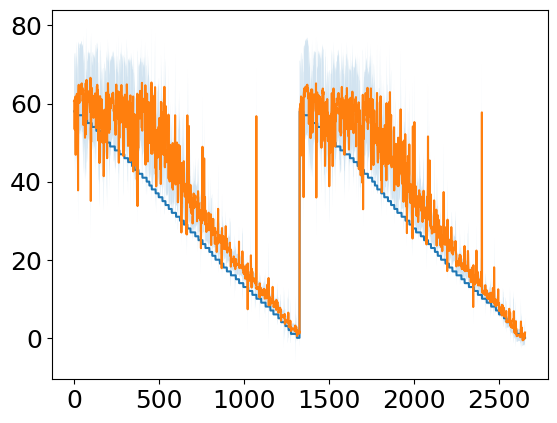

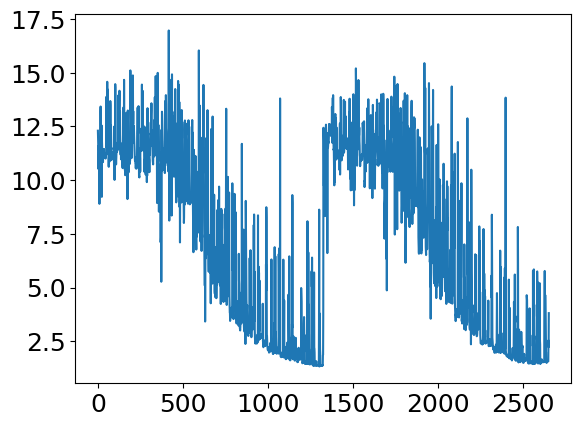

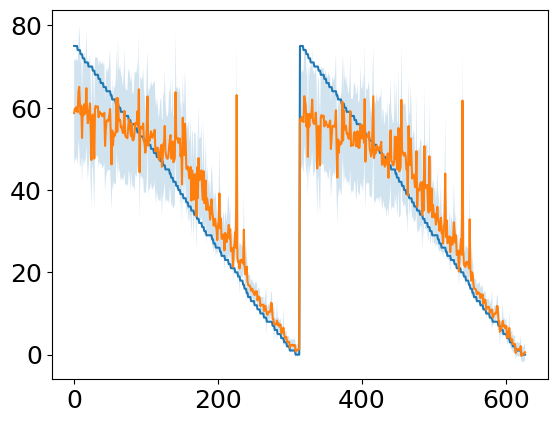

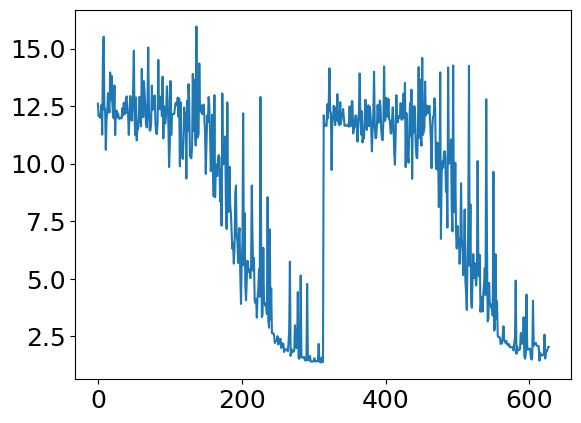

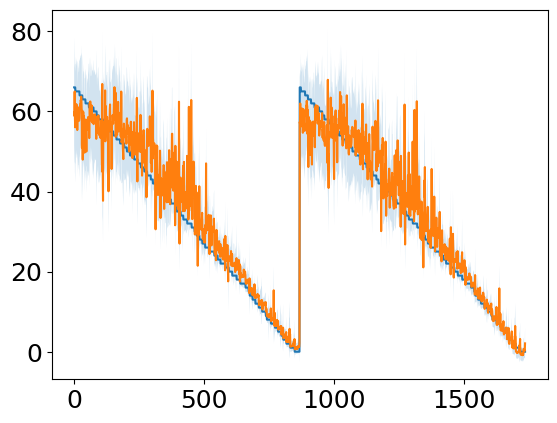

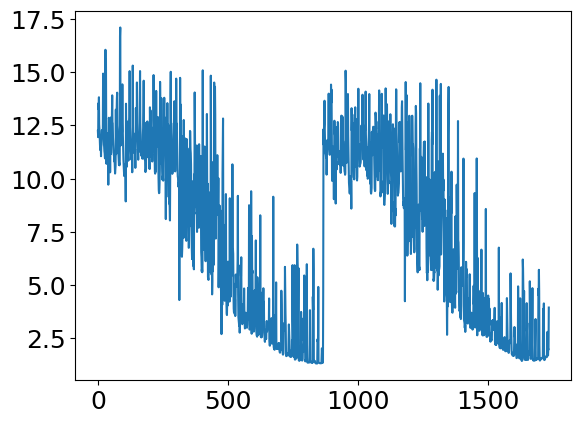

In [13]:
y_true = allresults_NNdf[allresults_NNdf['dataset']=='test11']['True'].values
y_pred = allresults_NNdf[allresults_NNdf['dataset']=='test11']['NN_mu_eff'].values
sigma_pred = allresults_NNdf[allresults_NNdf['dataset']=='test11']['NN_sigma_eff'].values
plt.figure()
plt.plot(y_true)
plt.plot(y_pred)
plt.fill_between(np.arange(len(y_pred)), y_pred-sigma_pred,y_pred+sigma_pred, alpha = 0.2)
plt.figure()
plt.plot(sigma_pred)



y_true = allresults_NNdf[allresults_NNdf['dataset']=='test14']['True'].values
y_pred = allresults_NNdf[allresults_NNdf['dataset']=='test14']['NN_mu_eff'].values
sigma_pred = allresults_NNdf[allresults_NNdf['dataset']=='test14']['NN_sigma_eff'].values
plt.figure()
plt.plot(y_true)
plt.plot(y_pred)
plt.fill_between(np.arange(len(y_pred)), y_pred-sigma_pred,y_pred+sigma_pred, alpha = 0.2)
plt.figure()
plt.plot(sigma_pred)



y_true = allresults_NNdf[allresults_NNdf['dataset']=='test15']['True'].values
y_pred = allresults_NNdf[allresults_NNdf['dataset']=='test15']['NN_mu_eff'].values
sigma_pred = allresults_NNdf[allresults_NNdf['dataset']=='test15']['NN_sigma_eff'].values
plt.figure()
plt.plot(y_true)
plt.plot(y_pred)
plt.fill_between(np.arange(len(y_pred)), y_pred-sigma_pred,y_pred+sigma_pred, alpha = 0.2)
plt.figure()
plt.plot(sigma_pred)

14.80187640733116


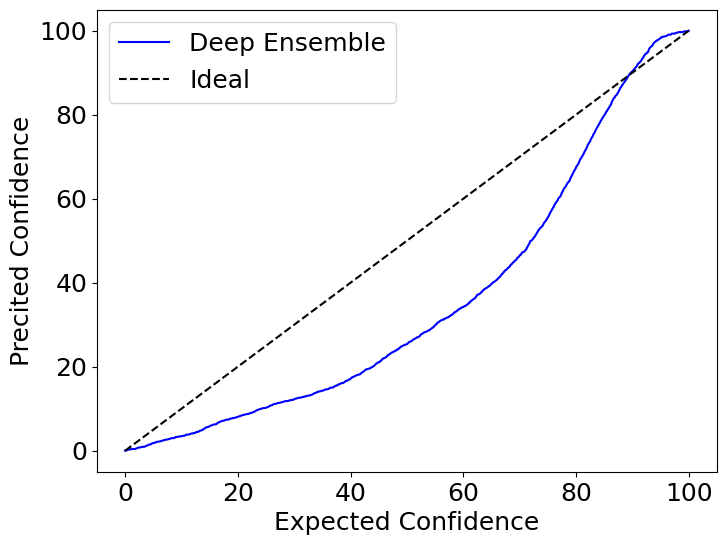

In [14]:
allresults_NNdf_sorted = allresults_NNdf.loc[allresults_NNdf['dataset']=='test11']
allresults_NNdf_sorted = allresults_NNdf_sorted.sort_values(by='True', ascending=True)

alphas, CI_DE,ECE = get_confidence_interval(allresults_NNdf_sorted['True'].values, 
                                       allresults_NNdf_sorted['NN_mu_eff'].values, 
                                       allresults_NNdf_sorted['NN_sigma_eff'].values)

print(ECE)


fig = plt.figure(figsize=(8,6))
plt.plot(alphas,CI_DE, color = 'blue', label='Deep Ensemble')
plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
plt.xlabel('Expected Confidence')
plt.ylabel('Precited Confidence')
plt.legend()


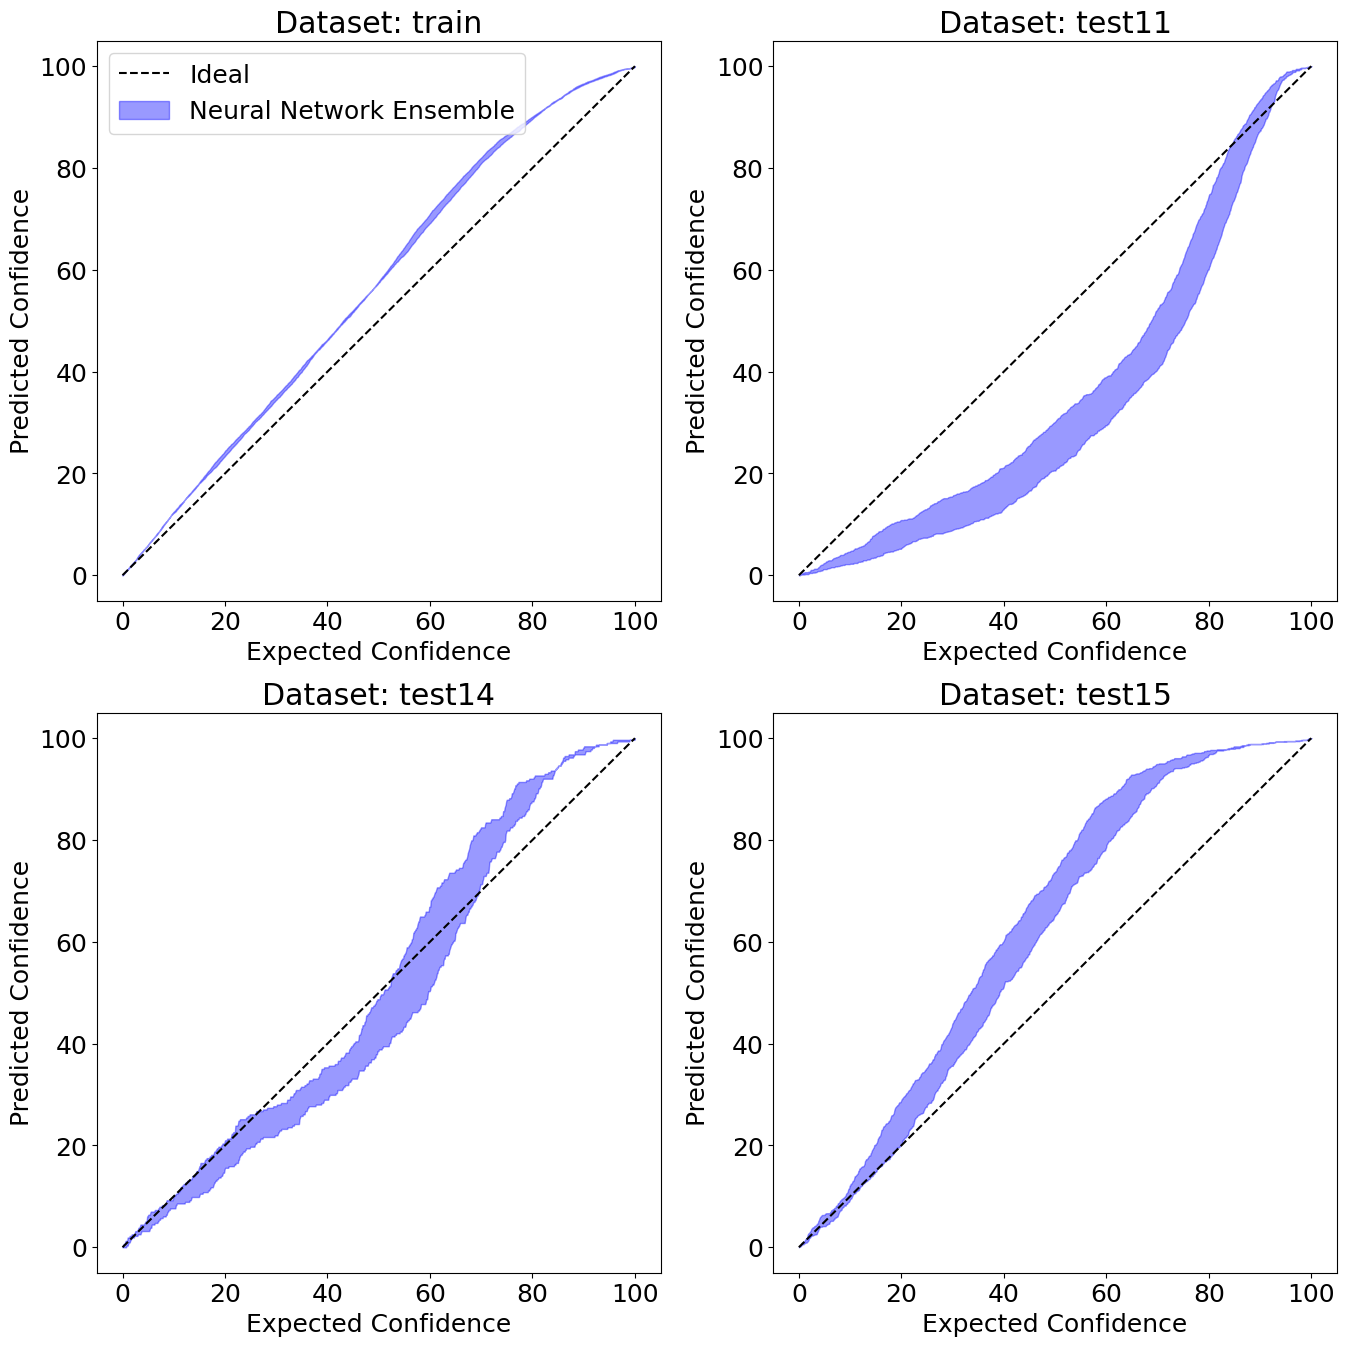

In [15]:
# plot calibration curve

dataset = ['train','test11', 'test14', 'test15']

niter = len(set(allresults_NNdf['iteration']))
fig, ax = plt.subplots(2,2,figsize=(16, 16))
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    
    allCI_NN = np.zeros((1000, niter))
    for myiter in range(niter):
        df = allresults_NNdf.loc[(allresults_NNdf['dataset']==dataset[myset]) & 
                                 (allresults_NNdf['iteration']==myiter)]
        exp_CI, CI_NN, ECE  = get_confidence_interval(df['True'].values, 
                                               df['NN_mu_eff'].values, 
                                               df['NN_sigma_eff'].values)
        allCI_NN[:,myiter] = CI_NN
        
    myax.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
    myax.fill_between(exp_CI,
                np.mean(allCI_NN, axis = 1)+np.std(allCI_NN, axis = 1),
                np.mean(allCI_NN, axis = 1)-np.std(allCI_NN, axis = 1),
                color='blue', alpha = 0.4, linestyle='None', label='Neural Network Ensemble')


    myax.set_title("Dataset: "+ dataset[myset])
    myax.set_xlabel("Expected Confidence")
    myax.set_ylabel("Predicted Confidence")
    if myset ==0:
        myax.legend()

## UQ Model: MC Dropout

In [16]:
def generate_trained_MCmodel(trainX, trainY, nepochs, actfn = 'relu'):
    """
    Inputs:
    trainX  - training input of shape (samples, num of features)
    trainY  - training output of shape (samples, 1)
    nepochs - number of epochs
    actfn   - activation function
    Outputs:
    model - MC Dropout model 
    """
    num_res_layers = 2
    n_inp_features = np.shape(trainX)[1]
    feature_input = Input(shape=(n_inp_features,), name="feature_input_layer")
    x = Dense(100, activation = actfn)(feature_input)
    x = Dropout(rate = 0.10)(x)
    for _ in range(num_res_layers):
        x  = Dense(50, activation = actfn)(x)
        x1 = Dense(50, activation = actfn)(x)
        x = x1 + x
        x = Dropout(rate = 0.10)(x)
    mu = Dense(1, activation = actfn)(x)
    #optimizer = Adam(learning_rate = 0.0004)
    model = Model(feature_input, mu)
    #model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY,shuffle=True, epochs=nepochs, verbose = 1)

    return model

In [17]:
nmodels = 1 # train models and select the best out of these
nep = 50
all_models_MC=[]
all_rmse_train_MC = np.zeros(nmodels,)
pbar = ProgressBar()
for i in pbar(range(nmodels)):
    model_MC = generate_trained_MCmodel(Xtrain_norm, Ytrain_norm, nep, 'relu')
    all_rmse_train_MC[i] = get_rmse(K.get_value(model_MC(Xtrain_norm))*(np.max(Ytrain)), Ytrain)
    all_models_MC.append(model_MC)


Train on 10527 samples
Epoch 1/50
10527/10527 [==============================] - 3s 240us/sample - loss: 0.0613
Epoch 2/50
10527/10527 [==============================] - 1s 100us/sample - loss: 0.0249
Epoch 3/50
10527/10527 [==============================] - 1s 103us/sample - loss: 0.0174
Epoch 4/50
10527/10527 [==============================] - 1s 102us/sample - loss: 0.0154
Epoch 5/50
10527/10527 [==============================] - 1s 102us/sample - loss: 0.0149
Epoch 6/50
10527/10527 [==============================] - 1s 100us/sample - loss: 0.0132
Epoch 7/50
10527/10527 [==============================] - 1s 102us/sample - loss: 0.0135
Epoch 8/50
10527/10527 [==============================] - 1s 102us/sample - loss: 0.0127
Epoch 9/50
10527/10527 [==============================] - 1s 105us/sample - loss: 0.0128
Epoch 10/50
10527/10527 [==============================] - 1s 103us/sample - loss: 0.0126
Epoch 11/50
10527/10527 [==============================] - 1s 101us/sample - loss: 0.0

100% |##############################################################################################################################|


In [18]:
select_modelMC = all_models_MC[np.argmin(all_rmse_train_MC)]
print("Train MAE: ", get_rmse(np.array(K.get_value(select_modelMC(Xtrain_norm)))[:,0]*(np.max(Ytrain)), Ytrain))
print("Test11 MAE: ", get_rmse(np.array(K.get_value(select_modelMC(Xtest11_norm)))[:,0]*(np.max(Ytrain)), Ytest11))
print("Test14 MAE: ", get_rmse(np.array(K.get_value(select_modelMC(Xtest14_norm)))[:,0]*(np.max(Ytrain)), Ytest14))
print("Test15 MAE: ", get_rmse(np.array(K.get_value(select_modelMC(Xtest15_norm)))[:,0]*(np.max(Ytrain)), Ytest15))
print("Test MAE: ", get_rmse(np.array(K.get_value(select_modelMC(Xtest_norm)))[:,0]*(np.max(Ytrain)), Ytest))

Train MAE:  8.088642
Test11 MAE:  8.156722
Test14 MAE:  8.871413
Test15 MAE:  6.0222716
Test MAE:  7.5890427


In [19]:
model_train_bool = True
nmodels = 1 # total models trained and best one picked
nensemble_size = 50 # run these many times per each select model with dropout
niter = 2
if model_train_bool:


    allCI_MC = np.zeros((1000, niter))
    pbar=ProgressBar()
    allresults_MCdf = pd.DataFrame()

    for myiter in pbar(range(niter)): # for each independent iteration
        all_models_MC=[]
        all_rmse_train_MC = np.zeros(nmodels,)
        pbar = ProgressBar()
        for i in range(nmodels): # train multiple models to select the best
            model_MC = generate_trained_MCmodel(Xtrain_norm, Ytrain_norm, nep, 'relu')
            all_rmse_train_MC[i] = get_rmse(K.get_value(model_MC(Xtrain_norm))*(np.max(Ytrain)), Ytrain)
            all_models_MC.append(model_MC)

        select_modelMC = all_models_MC[np.argmin(all_rmse_train_MC)] # best model

        for myset in dataset: # execute the model for all the datasets
            exec("Xnorm =X"+myset+"_norm")
            exec("Y =Y"+myset)

            result_df = pd.DataFrame(Y, columns = ['True'])
            result_df['dataset'] = myset
            for i in range(nensemble_size): # run the best model multiple times with dropout enabled
                result_df["MC_mu_"+str(i)] = K.get_value(select_modelMC(Xnorm, training=True))*(np.max(Ytrain))

            result_df['iteration'] = myiter
            allresults_MCdf = pd.concat([allresults_MCdf, result_df], axis = 0)
        allresults_MCdf = get_ensemble(allresults_MCdf, "MC", nensemble_size)
    allresults_MCdf.to_excel("results/MCDropout_CMAPPS_prediction_results_resnet.xlsx")  
else:
    #allresults_MCdf=pd.read_excel("MCDropout_battery_prediction_results.xlsx")  
    pass

Train on 10527 samples
Epoch 1/50
10527/10527 [==============================] - 3s 262us/sample - loss: 0.1034
Epoch 2/50
10527/10527 [==============================] - 1s 104us/sample - loss: 0.0264
Epoch 3/50
10527/10527 [==============================] - 1s 102us/sample - loss: 0.0183
Epoch 4/50
10527/10527 [==============================] - 1s 103us/sample - loss: 0.0160
Epoch 5/50
10527/10527 [==============================] - 1s 105us/sample - loss: 0.0146
Epoch 6/50
10527/10527 [==============================] - 1s 104us/sample - loss: 0.0138
Epoch 7/50
10527/10527 [==============================] - 1s 104us/sample - loss: 0.0136
Epoch 8/50
10527/10527 [==============================] - 1s 104us/sample - loss: 0.0135
Epoch 9/50
10527/10527 [==============================] - 1s 103us/sample - loss: 0.0126
Epoch 10/50
10527/10527 [==============================] - 1s 101us/sample - loss: 0.0121
Epoch 11/50
10527/10527 [==============================] - 1s 106us/sample - loss: 0.0

Train on 10527 samples
Epoch 1/50
10527/10527 [==============================] - 4s 377us/sample - loss: 0.0610
Epoch 2/50
10527/10527 [==============================] - 1s 105us/sample - loss: 0.0255
Epoch 3/50
10527/10527 [==============================] - 1s 102us/sample - loss: 0.0183
Epoch 4/50
10527/10527 [==============================] - 1s 102us/sample - loss: 0.0160
Epoch 5/50
10527/10527 [==============================] - 1s 104us/sample - loss: 0.0142
Epoch 6/50
10527/10527 [==============================] - 1s 104us/sample - loss: 0.0136
Epoch 7/50
10527/10527 [==============================] - 1s 106us/sample - loss: 0.0132
Epoch 8/50
10527/10527 [==============================] - 1s 110us/sample - loss: 0.0134
Epoch 9/50
10527/10527 [==============================] - 1s 105us/sample - loss: 0.0130
Epoch 10/50
10527/10527 [==============================] - 1s 104us/sample - loss: 0.0116
Epoch 11/50
10527/10527 [==============================] - 1s 106us/sample - loss: 0.0

100% |##############################################################################################################################|


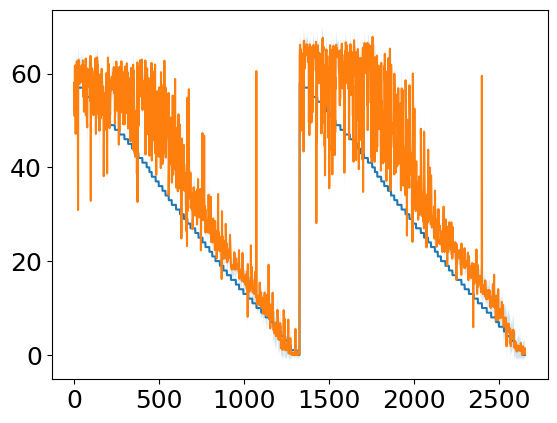

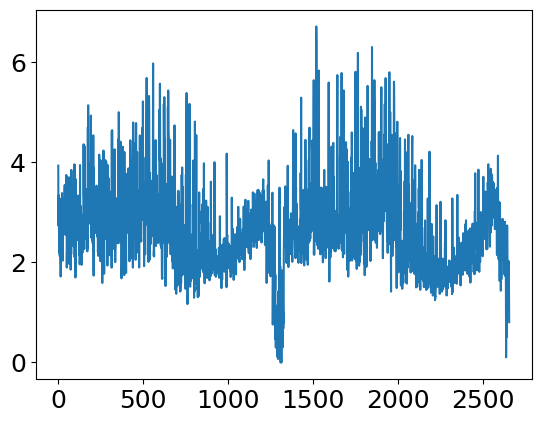

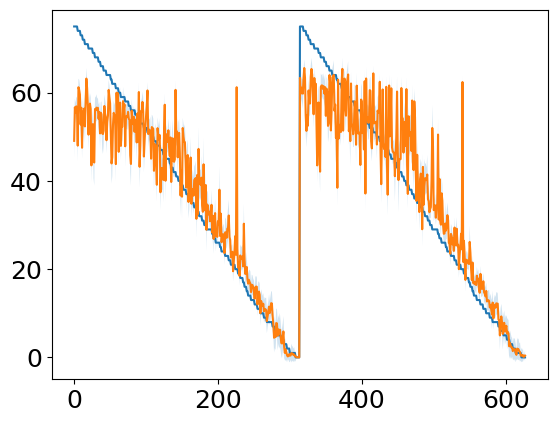

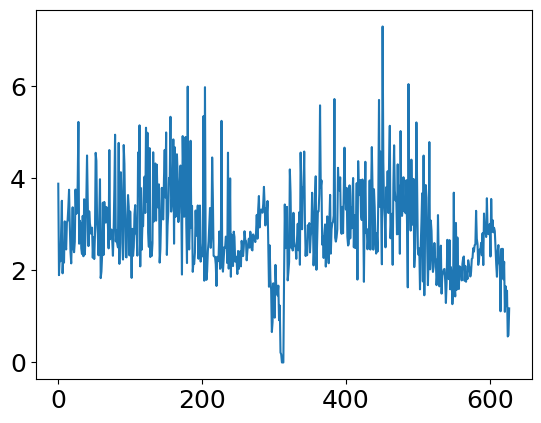

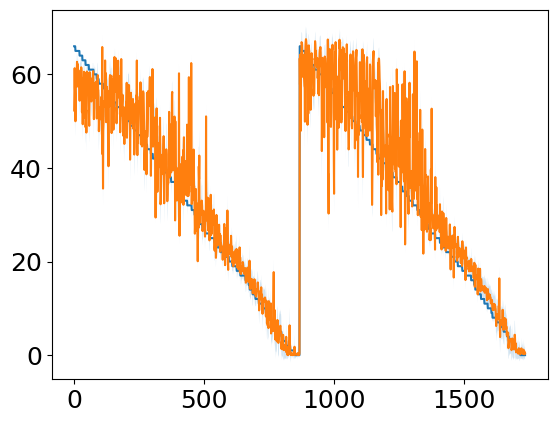

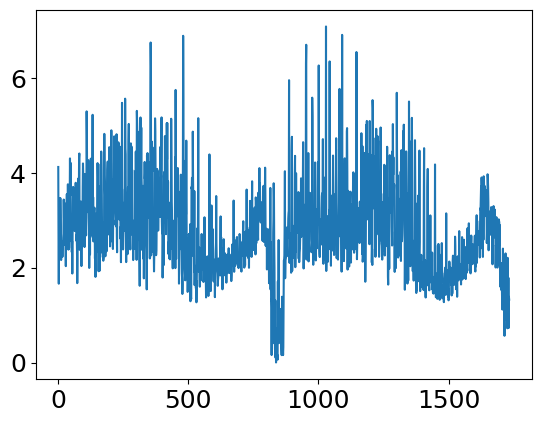

In [20]:
y_true = allresults_MCdf[allresults_MCdf['dataset']=='test11']['True'].values
y_pred = allresults_MCdf[allresults_MCdf['dataset']=='test11']['MC_mu_eff'].values
sigma_pred = allresults_MCdf[allresults_MCdf['dataset']=='test11']['MC_sigma_eff'].values
plt.figure()
plt.plot(y_true)
plt.plot(y_pred)
plt.fill_between(np.arange(len(y_pred)), y_pred-sigma_pred,y_pred+sigma_pred, alpha = 0.2)
plt.figure()
plt.plot(sigma_pred)



y_true = allresults_MCdf[allresults_MCdf['dataset']=='test14']['True'].values
y_pred = allresults_MCdf[allresults_MCdf['dataset']=='test14']['MC_mu_eff'].values
sigma_pred = allresults_MCdf[allresults_MCdf['dataset']=='test14']['MC_sigma_eff'].values
plt.figure()
plt.plot(y_true)
plt.plot(y_pred)
plt.fill_between(np.arange(len(y_pred)), y_pred-sigma_pred,y_pred+sigma_pred, alpha = 0.2)
plt.figure()
plt.plot(sigma_pred)



y_true = allresults_MCdf[allresults_MCdf['dataset']=='test15']['True'].values
y_pred = allresults_MCdf[allresults_MCdf['dataset']=='test15']['MC_mu_eff'].values
sigma_pred = allresults_MCdf[allresults_MCdf['dataset']=='test15']['MC_sigma_eff'].values
plt.figure()
plt.plot(y_true)
plt.plot(y_pred)
plt.fill_between(np.arange(len(y_pred)), y_pred-sigma_pred,y_pred+sigma_pred, alpha = 0.2)
plt.figure()
plt.plot(sigma_pred)

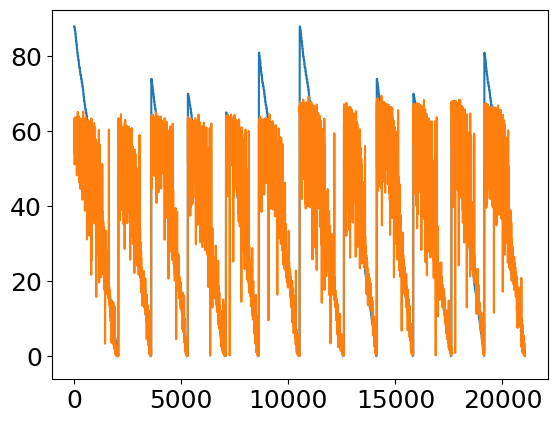

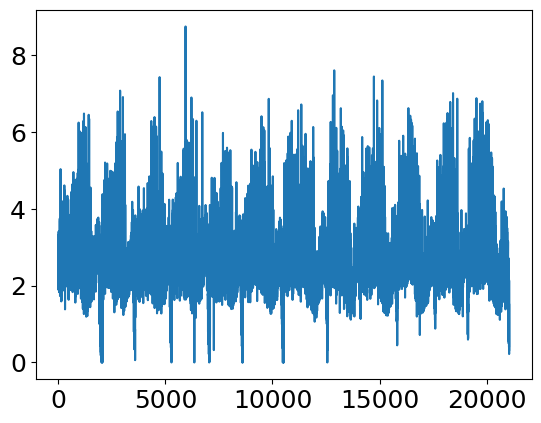

In [21]:
y_true = allresults_MCdf[allresults_MCdf['dataset']=='train']['True'].values
y_pred = allresults_MCdf[allresults_MCdf['dataset']=='train']['MC_mu_eff'].values
sigma_pred = allresults_MCdf[allresults_MCdf['dataset']=='train']['MC_sigma_eff'].values
plt.figure()
plt.plot(y_true)
plt.plot(y_pred)
plt.fill_between(np.arange(len(y_pred)), y_pred-sigma_pred,y_pred+sigma_pred, alpha = 0.2)
plt.figure()
plt.plot(sigma_pred)

## Results - Visualization

/local/home/lbiggio/UQ_ML_Review/UQ/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2343: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/local/home/lbiggio/UQ_ML_Review/UQ/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2344: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


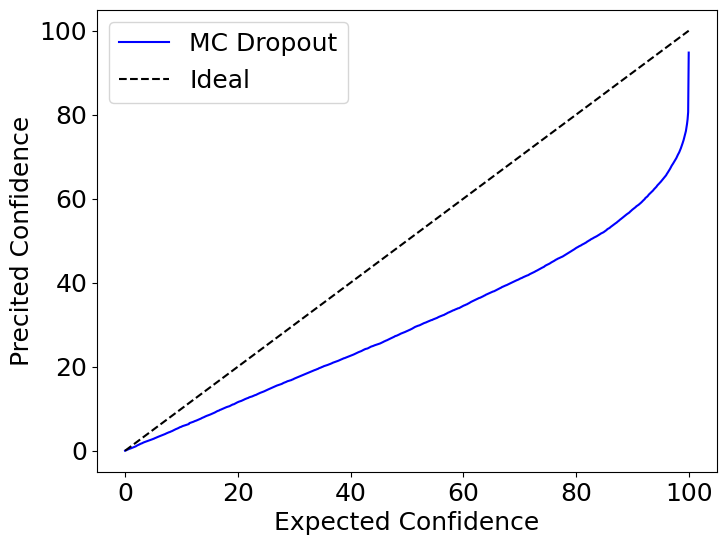

In [22]:
dataset_='train'
allresults_MCdf_ = allresults_MCdf[allresults_MCdf['dataset']==dataset_].sort_values(by='True', ascending=True)

alphas, CI_DE,_ = get_confidence_interval(allresults_MCdf_['True'].values, 
                                       allresults_MCdf_['MC_mu_eff'].values, 
                                       allresults_MCdf_['MC_sigma_eff'].values)
fig = plt.figure(figsize=(8,6))
plt.plot(alphas,CI_DE, color = 'blue', label='MC Dropout')
plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
plt.xlabel('Expected Confidence')
plt.ylabel('Precited Confidence')
plt.legend()

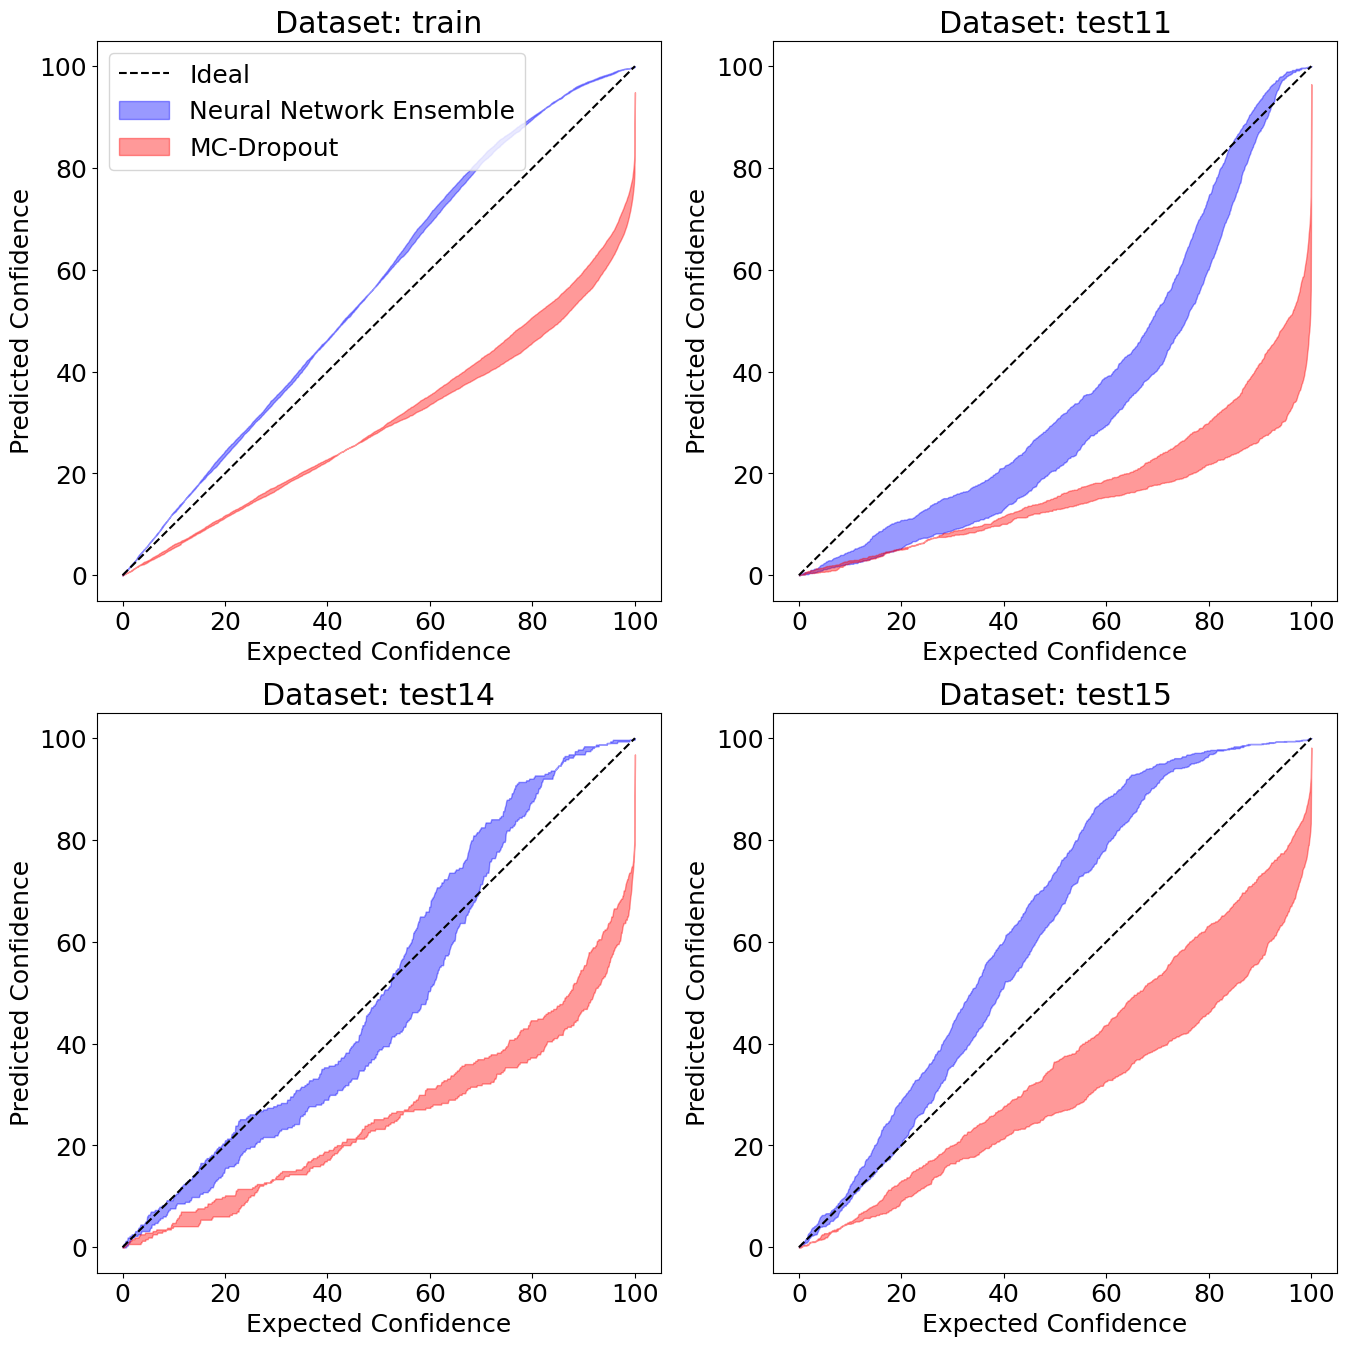

In [23]:
fig, ax = plt.subplots(2,2,figsize=(16, 16))
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    
    allCI_NN = np.zeros((1000, niter))
    allCI_MC = np.zeros((1000, niter))
    for myiter in range(niter):
        # MC dropout
        df = allresults_MCdf.loc[(allresults_MCdf['dataset']==dataset[myset]) & 
                                 (allresults_MCdf['iteration']==myiter)]
        exp_CI, CI_MC, ECE = get_confidence_interval(df['True'].values, 
                                               df['MC_mu_eff'].values, 
                                               df['MC_sigma_eff'].values)
        allCI_MC[:,myiter] = CI_MC
        
        # Neural Network Ensemble
        df = allresults_NNdf.loc[(allresults_NNdf['dataset']==dataset[myset]) & 
                                 (allresults_NNdf['iteration']==myiter)]
        exp_CI, CI_NN, ECE = get_confidence_interval(df['True'].values, 
                                               df['NN_mu_eff'].values, 
                                               df['NN_sigma_eff'].values)
        allCI_NN[:,myiter] = CI_NN
        
        
    myax.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
    myax.fill_between(exp_CI,
                np.mean(allCI_NN, axis = 1)+np.std(allCI_NN, axis = 1),
                np.mean(allCI_NN, axis = 1)-np.std(allCI_NN, axis = 1),
                color='blue', alpha = 0.4, linestyle='None', label='Neural Network Ensemble')
    
    myax.fill_between(exp_CI,
                np.mean(allCI_MC, axis = 1)+np.std(allCI_MC, axis = 1),
                np.mean(allCI_MC, axis = 1)-np.std(allCI_MC, axis = 1),
                color='red', alpha = 0.4, linestyle='None', label='MC-Dropout')


    myax.set_title("Dataset: "+ dataset[myset])
    myax.set_xlabel("Expected Confidence")
    myax.set_ylabel("Predicted Confidence")
    if myset ==0:
        myax.legend()